## Adiciona fontes externas ao projeto

In [ ]:
%pip install numpy duckdb seaborn matplotlib

In [2]:
import pandas as pd
import numpy as np
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./Crimes_2019_to_2024_Limpo.csv')
df['date_key'] = pd.to_datetime(df['date_key'])

##### Dataset de nomes das areas comunitarias de Chicago

In [3]:
df_nomes = pd.read_csv('./dados externos/Community_Areas.csv')

# Apaga colunas desnecessarias
df_nomes = df_nomes[['AREA_NUM_1', 'COMMUNITY']]

In [4]:
# muda nome das colunas pra facilitar o merge
df_nomes = df_nomes.rename(columns={'AREA_NUM_1': 'Community Area'})
df_nomes = df_nomes.rename(columns={'COMMUNITY': 'Community Area Name'})

# garante que community area é inteiro
df_nomes['Community Area'] = df_nomes['Community Area'].astype(int)

df_nomes.head()

,Community Area,Community Area Name
0,1,ROGERS PARK
1,2,WEST RIDGE
2,3,UPTOWN
3,4,LINCOLN SQUARE
4,5,NORTH CENTER


##### Dataset com a densidade populacional das areas comunitarias de Chicago

In [5]:
df_densidade = pd.read_csv('./dados externos/Community_Areas_Density.csv')

# Apaga colunas desnecessarias
df_densidade = df_densidade[['Community Area', 'Community_Area_Population', 'Community_Area_Density']]

In [6]:
# remove virgulas dos numeros pra conversao
df_densidade['Community_Area_Density'] = df_densidade['Community_Area_Density'].str.replace(',', '')

# garante que density é float e population é int
df_densidade['Community_Area_Density'] = df_densidade['Community_Area_Density'].astype(float)
df_densidade['Community_Area_Population'] = df_densidade['Community_Area_Population'].astype(int)

# muda o nome da coluna pra facilitar o merge
df_densidade = df_densidade.rename(columns={'Community Area': 'Community Area Name'})

df_densidade.head()

,Community Area Name,Community_Area_Population,Community_Area_Density
0,ROGERS PARK,54388,29558.70
1,WEST RIDGE,78227,22160.62
2,UPTOWN,57331,24711.64
3,LINCOLN SQUARE,41673,16278.52
4,NORTH CENTER,35408,17272.20


##### Dataset com Feriados

In [7]:
df_feriados = pd.read_csv('./dados externos/City_Holidays.csv')

# Apaga as linhas do 'feriado' "Day After Thanksgiving"
df_feriados = df_feriados[df_feriados['holiday_name'] != 'Day After Thanksgiving']

# Apaga colunas desnecessarias
df_feriados = df_feriados[['observed_date']]

# adiciona coluna date_key pro merge
df_feriados['date_key'] = pd.to_datetime(df_feriados['observed_date']).dt.normalize()

# Seleciona so os anos de 2019 a 2024
df_feriados = df_feriados[(df_feriados['date_key'] >= '2019-01-01') & (df_feriados['date_key'] <= '2024-12-31')]

# Adiciona coluna "is_holiday" pra facilitar integração
df_feriados['is_holiday'] = True

# apaga coluna observed_date
df_feriados = df_feriados.drop(columns=['observed_date'])

In [8]:
df_feriados.head()

,date_key,is_holiday
99,2019-01-01,True
100,2019-01-21,True
101,2019-02-18,True
102,2019-05-27,True
103,2019-07-04,True


##### Dataset com o clima de Chicago

In [9]:
df_clima = pd.read_csv('./dados externos/Climate.csv')

# formata a data
df_clima['date_key'] = pd.to_datetime(df_clima['date']).dt.normalize()

# renomeia colunas pra facilitar leitura
df_clima = df_clima.rename(columns={
    'temperature_2m_max': 'temp_max',
    'temperature_2m_min': 'temp_min',
    'precipitation_sum': 'rain_mm',
    'snowfall_sum': 'snow_cm'
})

colunas_clima = ['date_key', 'temp_max', 'temp_min', 'rain_mm', 'snow_cm']
df_clima = df_clima[colunas_clima]

df_clima.head()

,date_key,temp_max,temp_min,rain_mm,snow_cm
0,2019-01-01,1.3,-2.7,0.8,0.63
1,2019-01-02,0.0,-3.5,0.1,0.14
2,2019-01-03,4.4,-4.9,0.0,0.00
3,2019-01-04,8.4,-1.0,0.0,0.00
4,2019-01-05,10.3,-0.8,0.0,0.00


##### Concatenação dos dados pro dataset principal

In [10]:
df_concat = df.copy()
print(f"Tamanho inicial do df: {df_concat.shape}")

# merge com nomes das areas
df_concat = pd.merge(df_concat, df_nomes, on='Community Area', how='left')
print(f"Tamanho apos merge com nomes: {df_concat.shape}")

# merge com o clima
df_concat = pd.merge(df_concat, df_clima, on='date_key', how='left')
print(f"Tamanho apos merge com clima: {df_concat.shape}")

# merge com densidade
df_concat = pd.merge(df_concat, df_densidade, on='Community Area Name', how='left')
print(f"Tamanho apos merge com densidade: {df_concat.shape}")

# merge com feriados
df_concat = pd.merge(df_concat, df_feriados, on='date_key', how='left')
print(f"Tamanho apos merge com feriados: {df_concat.shape}")

Tamanho inicial do df: (1445690, 11)
Tamanho apos merge com nomes: (1445690, 12)
Tamanho apos merge com clima: (1445690, 16)
Tamanho apos merge com densidade: (1445690, 18)
Tamanho apos merge com feriados: (1445690, 19)


In [ ]:
# Converte os NaN na coluna 'is_holiday' para False
df_concat['is_holiday'] = df_concat['is_holiday'].fillna(False)

# Apaga as linhas onde não foi possível encontrar a densidade
df_concat.dropna(subset=['Community_Area_Density'], inplace=True)

df_concat.isnull().sum()

##### Limpeza Final

In [12]:
df_concat['datetime'] = pd.to_datetime(df_concat['datetime'])

# Extrai a hora
df_concat['hour'] = df_concat['datetime'].dt.hour

# Extrai o mês
df_concat['month'] = df_concat['datetime'].dt.month

# Extrai o dia da semana
# (Segunda=0, Domingo=6)
df_concat['day_of_week'] = df_concat['datetime'].dt.dayofweek

In [13]:
colunas_para_remover_final = [
    'ID',
    'Date',
    'date_key',
    'Community Area'
]

# Apaga as colunas
df_final = df_concat.drop(columns=colunas_para_remover_final)

print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1435930 entries, 0 to 1445689
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Primary Type               1435930 non-null  object        
 1   Description                1435930 non-null  object        
 2   Location Description       1435930 non-null  object        
 3   Arrest                     1435930 non-null  bool          
 4   Domestic                   1435930 non-null  bool          
 5   Year                       1435930 non-null  int64         
 6   datetime                   1435930 non-null  datetime64[ns]
 7   Community Area Name        1435930 non-null  object        
 8   temp_max                   1435930 non-null  float64       
 9   temp_min                   1435930 non-null  float64       
 10  rain_mm                    1435930 non-null  float64       
 11  snow_cm                    1435930 non-nul

In [14]:
# Melhorar o ruido da feature 'hour' criando uma nova coluna 'period_of_day'

h = df_final['datetime'].dt.hour
m = df_final['datetime'].dt.minute
s = df_final['datetime'].dt.second

cond_incerta = ((h == 0) | (h == 12) & (m == 0) & (s == 0))
cond_madrugada = ((h >= 1) & (h <= 5) | ((h == 0) & ((m != 0) | (s != 0))))
cond_manha = (h >= 6) & (h <= 11)
cond_tarde = ((h >= 13) & (h <= 17) | ((h == 12) & ((m != 0) | (s != 0))))
cond_noite = (h >= 18) & (h <= 23)

condlist = [cond_incerta, cond_madrugada, cond_manha, cond_tarde, cond_noite]
choicelist = ['UNCERTAIN_TIME', 'DAWN', 'MORNING', 'AFTERNOON', 'NIGHT']

df_final['period_of_day'] = np.select(condlist, choicelist, default='OTHER')

print("Coluna 'period_of_day' criada com sucesso.")

print(df_final['period_of_day'].value_counts())

Coluna 'period_of_day' criada com sucesso.
period_of_day
NIGHT             414309
AFTERNOON         413865
MORNING           297893
DAWN              174388
UNCERTAIN_TIME    135475
Name: count, dtype: int64


In [15]:
df_final.head()

,Primary Type,Description,Location Description,Arrest,Domestic,Year,datetime,Community Area Name,temp_max,temp_min,rain_mm,snow_cm,Community_Area_Population,Community_Area_Density,is_holiday,hour,month,day_of_week,period_of_day
0,OFFENSE INVOLVING CHILDREN,CHILD PORNOGRAPHY,RESIDENCE,True,False,2022,2022-07-29 03:39:00,SOUTH LAWNDALE,26.4,16.2,0.2,0.0,68798.0,14988.67,False,3,7,4,DAWN
1,NARCOTICS,MANUFACTURE / DELIVER - CRACK,SIDEWALK,True,False,2023,2023-01-03 16:44:00,WEST GARFIELD PARK,12.7,4.2,13.1,0.0,15619.0,12202.34,False,16,1,1,AFTERNOON
2,ROBBERY,AGGRAVATED VEHICULAR HIJACKING,STREET,True,False,2020,2020-08-10 09:45:00,WEST TOWN,29.6,20.8,7.5,0.0,86598.0,18907.86,False,9,8,0,MORNING
3,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,2023,2023-09-06 17:00:00,LOOP,29.7,20.3,8.4,0.0,42181.0,25564.24,False,17,9,2,AFTERNOON
4,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,2023,2023-09-06 11:00:00,LOOP,29.7,20.3,8.4,0.0,42181.0,25564.24,False,11,9,2,MORNING


In [23]:
# Exporta o dataframe final para CSV e parquet
df_final.to_csv('../Etapa 3 - Analise Exploratória/Crimes_2019_to_2024_Final.csv', index=False)
df_final.to_parquet('../Etapa 3 - Analise Exploratória/Crimes_2019_to_2024_Final.parquet', index=False)

## Consultas e Visualizações

In [17]:
df_bruto = pd.read_csv('./Crimes_2019_to_2024.csv')
df_final = pd.read_csv('../Etapa 3 - Analise Exploratória/Crimes_2019_to_2024_Final.csv')

In [18]:
# Analise 1: Atualização das linhas nulas na coluna 'Location Description' para "UNSPECIFIED" para não correr riscos com modelos de ML

query_antes = """
SELECT COUNT(*) as total_de_nulos
FROM df_bruto
WHERE "Location Description" IS NULL
"""

query_depois = """
SELECT COUNT(*) as total_de_nulos
FROM df_final
WHERE "Location Description" IS NULL
"""

print("--- ANTES DA LIMPEZA ---")
print(duckdb.query(query_antes).df())
print("\n--- DEPOIS DA LIMPEZA ---")
print(duckdb.query(query_depois).df())

--- ANTES DA LIMPEZA ---
   total_de_nulos
0            8040

--- DEPOIS DA LIMPEZA ---
   total_de_nulos
0               0


In [19]:
# Analise 2: Remoção de linhas com 'Community Area' nulo

query_antes_ca = """
SELECT COUNT(*) as total_de_nulos
FROM df_bruto
WHERE "Community Area" IS NULL
"""

query_depois_ca = """
SELECT COUNT(*) as total_de_nulos
FROM df_final
WHERE "Community Area Name" IS NULL 
-- Usamos 'Community Area Name' pq a coluna 'Community Area' foi removida
-- Se o nome é nulo, é pq a área era nula.
"""

print("--- ANTES DA LIMPEZA ---")
print(duckdb.query(query_antes_ca).df())
print("\n--- DEPOIS DA LIMPEZA ---")
print(duckdb.query(query_depois_ca).df())

--- ANTES DA LIMPEZA ---
   total_de_nulos
0             109

--- DEPOIS DA LIMPEZA ---
   total_de_nulos
0               0


In [20]:
# Analise 3: Erros de Integridade de Dados ('Density')

# Para mostrar isso, precisamos recriar o 'antes'
df_concat_antes_limpeza = pd.merge(df, df_nomes, on='Community Area', how='left')
df_concat_antes_limpeza = pd.merge(df_concat_antes_limpeza, df_densidade, on='Community Area Name', how='left')

# As linhas com 'Density' nula foram removidas no processo de limpeza final

print(f"Linhas com 'Density' nula (ANTES da limpeza final): {df_concat_antes_limpeza['Community_Area_Density'].isnull().sum()}")
print(f"Linhas com 'Density' nula (DEPOIS da limpeza final): {df_final['Community_Area_Density'].isnull().sum()}")

Linhas com 'Density' nula (ANTES da limpeza final): 9760
Linhas com 'Density' nula (DEPOIS da limpeza final): 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435930 entries, 0 to 1435929
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   datetime       1435930 non-null  object
 1   period_of_day  1435930 non-null  object
dtypes: object(2)
memory usage: 21.9+ MB
None


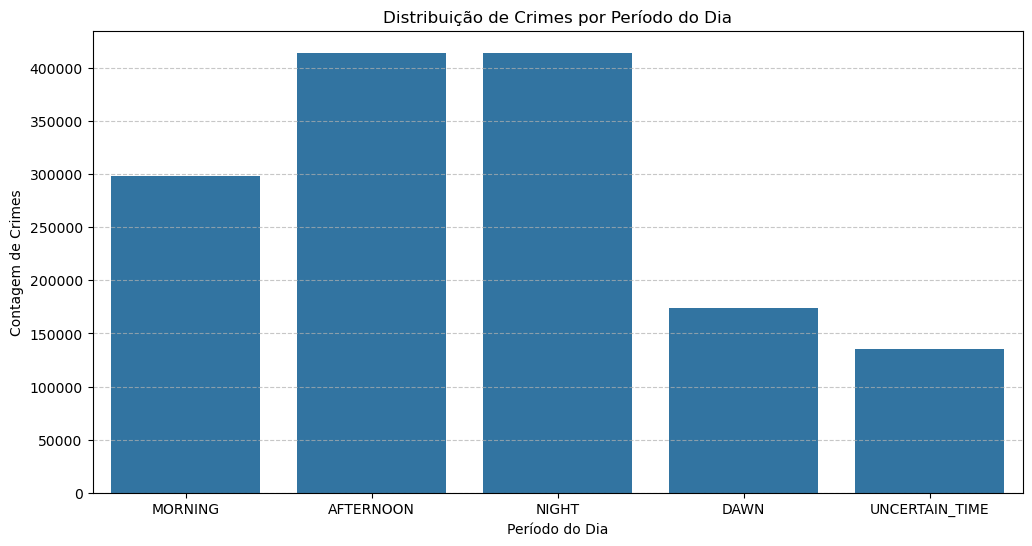

In [21]:
# Analise 4: Distribuição ANTES vs. DEPOIS (extração da feature 'periodo_do_dia')

print(df_final[['datetime', 'period_of_day']].info())

# O gráfico depois (que era impossível de fazer antes)

# aonde hora incerta é 0:00:00 ou 12:00:00
ordem_periodos = ['MORNING', 'AFTERNOON', 'NIGHT', 'DAWN', 'UNCERTAIN_TIME']

plt.figure(figsize=(12, 6))
sns.countplot(data=df_final, x='period_of_day', order=ordem_periodos)
plt.title('Distribuição de Crimes por Período do Dia')
plt.xlabel('Período do Dia')
plt.ylabel('Contagem de Crimes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()